# Working flow
1. import libs
2. load data and preprocess data (maybe create features)
3. split data to training and validation set
4. build model (graph)
5. train model and record performance

# 1. Import libs

In [359]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

# 2. Load data and preprocess data

In [338]:
from sklearn.datasets import load_digits
digits = load_digits()

In [339]:
x = digits.data
y = digits.target

In [340]:
print(x.shape)
print(y.shape)
print(x[0])
print(y[0])

(1797, 64)
(1797,)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
0


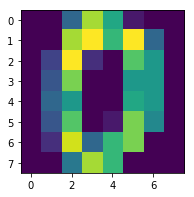

In [341]:
img = np.reshape(x[0], (8,8))

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()

In [342]:
# normalize x value to [0,1]
x_nor = x / np.max(x)
x_nor[0]

array([0.    , 0.    , 0.3125, 0.8125, 0.5625, 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.8125, 0.9375, 0.625 , 0.9375, 0.3125, 0.    ,
       0.    , 0.1875, 0.9375, 0.125 , 0.    , 0.6875, 0.5   , 0.    ,
       0.    , 0.25  , 0.75  , 0.    , 0.    , 0.5   , 0.5   , 0.    ,
       0.    , 0.3125, 0.5   , 0.    , 0.    , 0.5625, 0.5   , 0.    ,
       0.    , 0.25  , 0.6875, 0.    , 0.0625, 0.75  , 0.4375, 0.    ,
       0.    , 0.125 , 0.875 , 0.3125, 0.625 , 0.75  , 0.    , 0.    ,
       0.    , 0.    , 0.375 , 0.8125, 0.625 , 0.    , 0.    , 0.    ])

In [343]:
# one-hot encode y
y_onehot = np.eye(10)[y]

for i in range(10):
    print(y[i], y_onehot[i])

0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# 3. split data to training and validation set

In [344]:
x_train, x_vali, y_train, y_vali = train_test_split(x_nor, y_onehot, test_size=0.1, random_state=17)

In [345]:
print(x_train.shape, y_train.shape)
print(x_vali.shape, y_vali.shape)

(1617, 64) (1617, 10)
(180, 64) (180, 10)


# 4. build model (graph)

## using tensorflow lower component

In [354]:
# build a fully connected NN
tf.reset_default_graph()

# input placeholder
x = tf.placeholder(dtype=tf.float32, shape=(None, 64))

# label placeholder
y_real = tf.placeholder(dtype=tf.float32, shape=(None, 10))

with tf.variable_scope('hidden_layer1'):
    w1 = tf.get_variable(
        name='w1', 
        shape=(64, 25), 
        dtype=tf.float32, 
        initializer=tf.truncated_normal_initializer(stddev=0.1, seed=31))
    
    b1 = tf.get_variable(
        name='b1', 
        shape=(25), 
        dtype=tf.float32, 
        initializer=tf.constant_initializer(0))
    
    h1 = tf.nn.relu((tf.matmul(x, w1) + b1))
    
with tf.variable_scope('output_layer'):
    wo = tf.get_variable(
        name='wo', 
        shape=(25,10), 
        dtype=tf.float32, 
        initializer=tf.truncated_normal_initializer(stddev=0.1, seed=3))

    bo = tf.get_variable(
        name='bo', 
        shape=(10), 
        dtype=tf.float32, 
        initializer=tf.constant_initializer(0))
    
    y_pred = tf.nn.relu((tf.matmul(h1, wo) + bo))
    
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_real)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.name_scope('accuracy'):
    correct = tf.equal(
        tf.argmax(y_pred, axis=1), 
        tf.argmax(y_real, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))
    
with tf.name_scope('optimizer'):
    opt = tf.train.AdamOptimizer(learning_rate=0.001)
    update = opt.minimize(loss)

## using tensorflow layer

In [332]:
# build a fully connected NN
tf.reset_default_graph()

# input placeholder
x = tf.placeholder(dtype=tf.float32, shape=(None, 64))

# label placeholder
y_real = tf.placeholder(dtype=tf.float32, shape=(None, 10))

with tf.variable_scope('hidden_layer1'):
    h1 = tf.layers.dense(inputs=x, units=25, activation=tf.nn.relu)
    
with tf.variable_scope('output_layer'):   
    y_pred = tf.layers.dense(inputs=h1, units=10)
    
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_real)
    loss = tf.reduce_mean(cross_entropy)
    
with tf.name_scope('accuracy'):
    correct = tf.equal(
        tf.argmax(y_pred, axis=1), 
        tf.argmax(y_real, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))
    
with tf.name_scope('optimizer'):
    opt = tf.train.AdamOptimizer(learning_rate=0.001)
    update = opt.minimize(loss)

# 5. train model and record performance

In [355]:
def BatchGenerator(x, y, bs):
    index = np.arange(x.shape[0])
    batch_num = int(len(index) / bs) # drop last few data
    
    ind_sh = shuffle(index)
    x_sh = x[ind_sh]
    y_sh = y[ind_sh]
    for i in range (batch_num):
        x_batch = x_sh[i*bs : (i+1)*bs]
        y_batch = y_sh[i*bs : (i+1)*bs]
        yield x_batch, y_batch

In [362]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [363]:
loss_rec, accuracy_rec = [],[]
loss_v_rec, accuracy_v_rec = [],[]
bs = 32
epoch = 100

for i in tqdm(range(epoch)):
    gen = BatchGenerator(x_train, y_train, bs)
    while(True):
        batch = next(gen, None)
        if(batch == None):
            break
        sess.run([update], feed_dict={x:batch[0], y_real:batch[1]})
    
    l, acc = sess.run([loss, accuracy], feed_dict={x:x_train, y_real:y_train})
    loss_rec.append(l)
    accuracy_rec.append(acc)
    l_v, acc_v = sess.run([loss, accuracy], feed_dict={x:x_vali, y_real:y_vali})
    loss_v_rec.append(l_v)
    accuracy_v_rec.append(acc_v)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.72it/s]


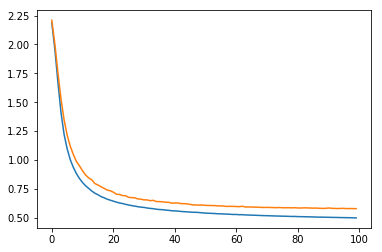

Final loss 0.4975384
Final validation loss 0.57789636


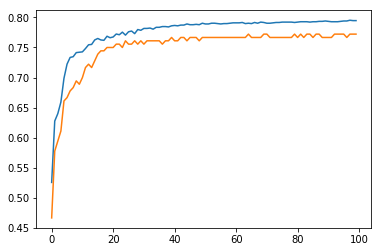

Final accuracy 0.7946815
Final validation accuracy 0.7722222


In [365]:
plt.plot(np.arange(len(loss_rec)), loss_rec)
plt.plot(np.arange(len(loss_v_rec)), loss_v_rec)
plt.show()
print('Final loss',loss_rec[-1])
print('Final validation loss',loss_v_rec[-1])

plt.plot(np.arange(len(accuracy_rec)), accuracy_rec)
plt.plot(np.arange(len(accuracy_v_rec)), accuracy_v_rec)
plt.show()
print('Final accuracy',accuracy_rec[-1])
print('Final validation accuracy',accuracy_v_rec[-1])